# New Rotation Calculation Work

I think I kinda should start from scratch to re-figure all this out and debug issues. This is gonna be largely from the rotation notebook, and probably will eventually go back there. But both I need to basically review everything since it's been basically a year since I tackled this seriously and I think some of my notation / code workings have changed.

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display
from IPython.display import Latex
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import Latex

import matplotlib as mpl
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
import MoleculeCalculation as mol

In [2]:
def mpReflectionOp(basis):
    # expects the LSI basis
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['L', ]
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

# No Rotation Movre Pischler

I wanted to set this up with the same code as I was using for the full calculation.

In [3]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [4]:
lsToJOp = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
fsOperator = mol.create_fsH(jiBasis2Atom)#fsOp(jiBasis2Atom)

In [5]:
Omega=0
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
caseASymHfs = mol.createCaseABasis_Sym([1],[0,1],[0], sigmavals=['g','u'])
for state in caseASymHfs:
    if math.isclose(state['|Omega|'], Omega):
        parityString = '+' if state['sigma_vxz'] == 1 else '-'
        symmetryLabel = str(Omega) + parityString + state['sigma']
        if symmetryLabel not in symmetrizedBases:
            symmetrizedBases[symmetryLabel] = []
        symmetrizedBases[symmetryLabel].append(state)

In [6]:
mostlySymmetrizedBases = {}
omegaIncluded=np.arange(1,6)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], sigmavals=['g', 'u'])
for Omega in omegaIncluded:
    for state in caseAMostlySymHfs:
        if math.isclose(state['Omega'], Omega):
            # parityString = '+' if state['sigma_vxz'] == 1 else '-'
            symmetryLabel = str(Omega) + state['sigma']
            if symmetryLabel not in mostlySymmetrizedBases:
                mostlySymmetrizedBases[symmetryLabel] = []
            mostlySymmetrizedBases[symmetryLabel].append(state)

In [7]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "\nbut this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 
but this differs from the literature value which is:  5.94492796981645e-48


In [8]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


## Create Symmetrized Fine Structure Hamiltonians

### $\Omega=0$

In [ ]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            sigma = mol.g if caseAState["sigma"] == "g" else mol.u
            nuclearNums = [caseAState['i'], caseAState['iota'],caseAState['i1'],caseAState['i2']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsToJOp )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)

### $\Omega=1,2$

The loop for 1 and 2 is slightly different since these states have one less symmetry.

In [11]:
for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [[], []]
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        sigma = mol.g if state["sigma"] == "g" else mol.u
        nuclearNums = [state['i'], state['iota'],state['i1'],state['i2'],]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        fsStates.append(sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsToJOp ));
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset=-1/2 * 2 * E_FS_5P12_5P32 / 3)

Working on states of symmetry 2u. 1 states


## Results

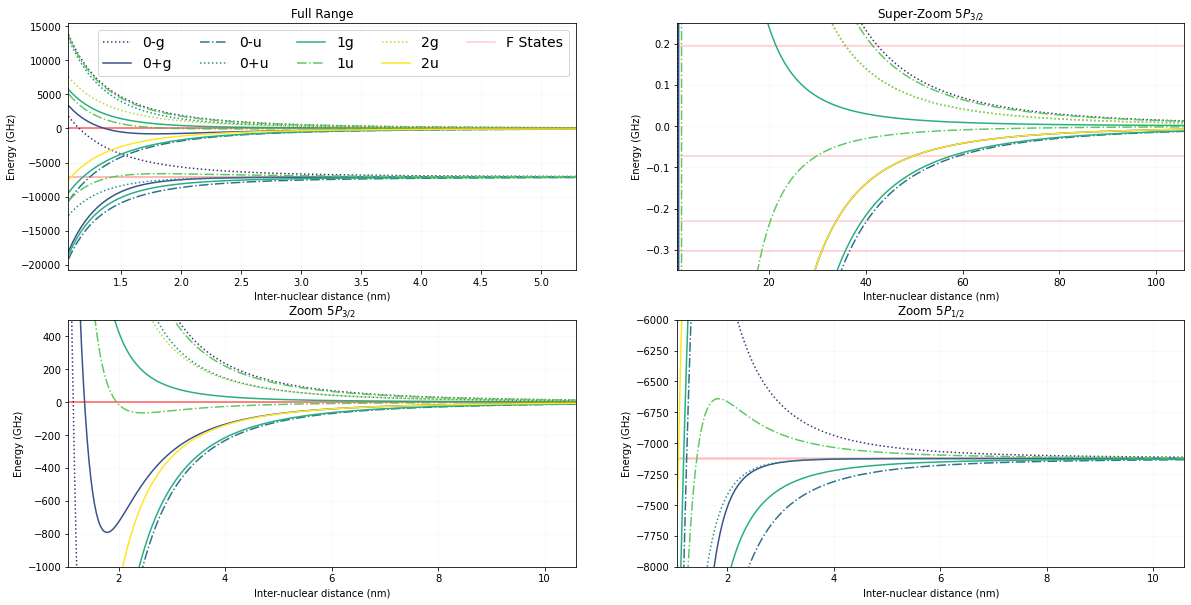

In [12]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases, **mostlySymmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.getBoH(C_3_val, rv, *basis).astype(float) + H_fs_phi[label]
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    ax.axhline(-0.0729113, alpha=0.2,color='r')
    ax.axhline(-0.2298518, alpha=0.2,color='r')
    ax.axhline(-0.30207388, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)

# No Rotation, Fully symmetrized Basis States

For rotation, I can't simply seperate out the Omega=0 and != 0 states, I need to work with them all together. I think the most sensible way to handle this is to have all the states use the "fully symmetrized" notation, even when not necessary, then it should be more consistent.

In [10]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [11]:
lsToJOp = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
fsOperator = mol.create_fsH(jiBasis2Atom)#fsOp(jiBasis2Atom)

In [12]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


In [13]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


## Create Symmetrized Fine Structure Hamiltonians

In [16]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for Omega in [0,1,2]:
    caseASymHfs = mol.createCaseABasis_Sym([1],[0,1],[0], sigmavals=['g','u'])
    for state in caseASymHfs:
        #print(state.keys())
        if state['Phi']<0:
            continue
        if math.isclose(state['|Omega|'], Omega):
            if Omega == 0:
                parityString = '+' if state['sigma_vxz'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['sigma']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)

### $\Omega=0$

In [23]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    #IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        print(indexes, signs)
        if state['|Omega|'] != 0:
            indexes = [indexes[0]]
            signs = [signs[0]]
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            sigma = mol.g if caseAState["sigma"] == "g" else mol.u
            #print(caseAState.keys())
            nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsToJOp )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)

Working on states of symmetry 0-g. 2 states
[5, 4] [1, -1]            
[0] [1]                   
Working on states of symmetry 0+g. 2 states
[5, 4] [1, 1]             
[1] [1]                   
Working on states of symmetry 0-u. 2 states
[7, 6] [1, -1]            
[2] [1]                   
Working on states of symmetry 0+u. 2 states
[7, 6] [1, 1]             
[3] [1]                   
Working on states of symmetry 1g. 3 states
[17, 16] [1, 1]           
[10, 8] [1, 1]            
[11, 9] [1, 1]            
Working on states of symmetry 1u. 3 states
[19, 18] [1, 1]           
[14, 12] [1, 1]           
[15, 13] [1, 1]           
Working on states of symmetry 2g. 1 states
[21, 20] [1, 1]           
Working on states of symmetry 2u. 1 states
[23, 22] [1, 1]           


In [24]:
H_fs_phi.keys()

dict_keys(['0-g', '0+g', '0-u', '0+u', '1g', '1u', '2g', '2u'])

In [25]:
H_fs_phi['1g']*1e-9/mc.h

array([[-2374.34, -2374.34,  2374.34],
       [-2374.34, -2374.34,  2374.34],
       [ 2374.34,  2374.34, -2374.34]])

### $\Omega=1,2$

The loop for 1 and 2 is slightly different since these states have one less symmetry.

for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [[], []]
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        sigma = mol.g if state["sigma"] == "g" else mol.u
        nuclearNums = [state['i'], state['iota'],state['i1'],state['i2'],]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        fsStates.append(sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsToJOp ));
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset=-1/2 * 2 * E_FS_5P12_5P32 / 3)

In [26]:
print(np.linalg.eig(H_fs_phi['0+g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0+u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2g']*1e-9/mc.h)[0])

[-7123.021    -0.   ]
[-7123.021    -0.   ]
[-7123.021    -0.   ]
[-7123.021    -0.   ]
[-7123.021     0.        0.   ]
[-7123.021     0.        0.   ]
[-0.]
[-0.]


## Results

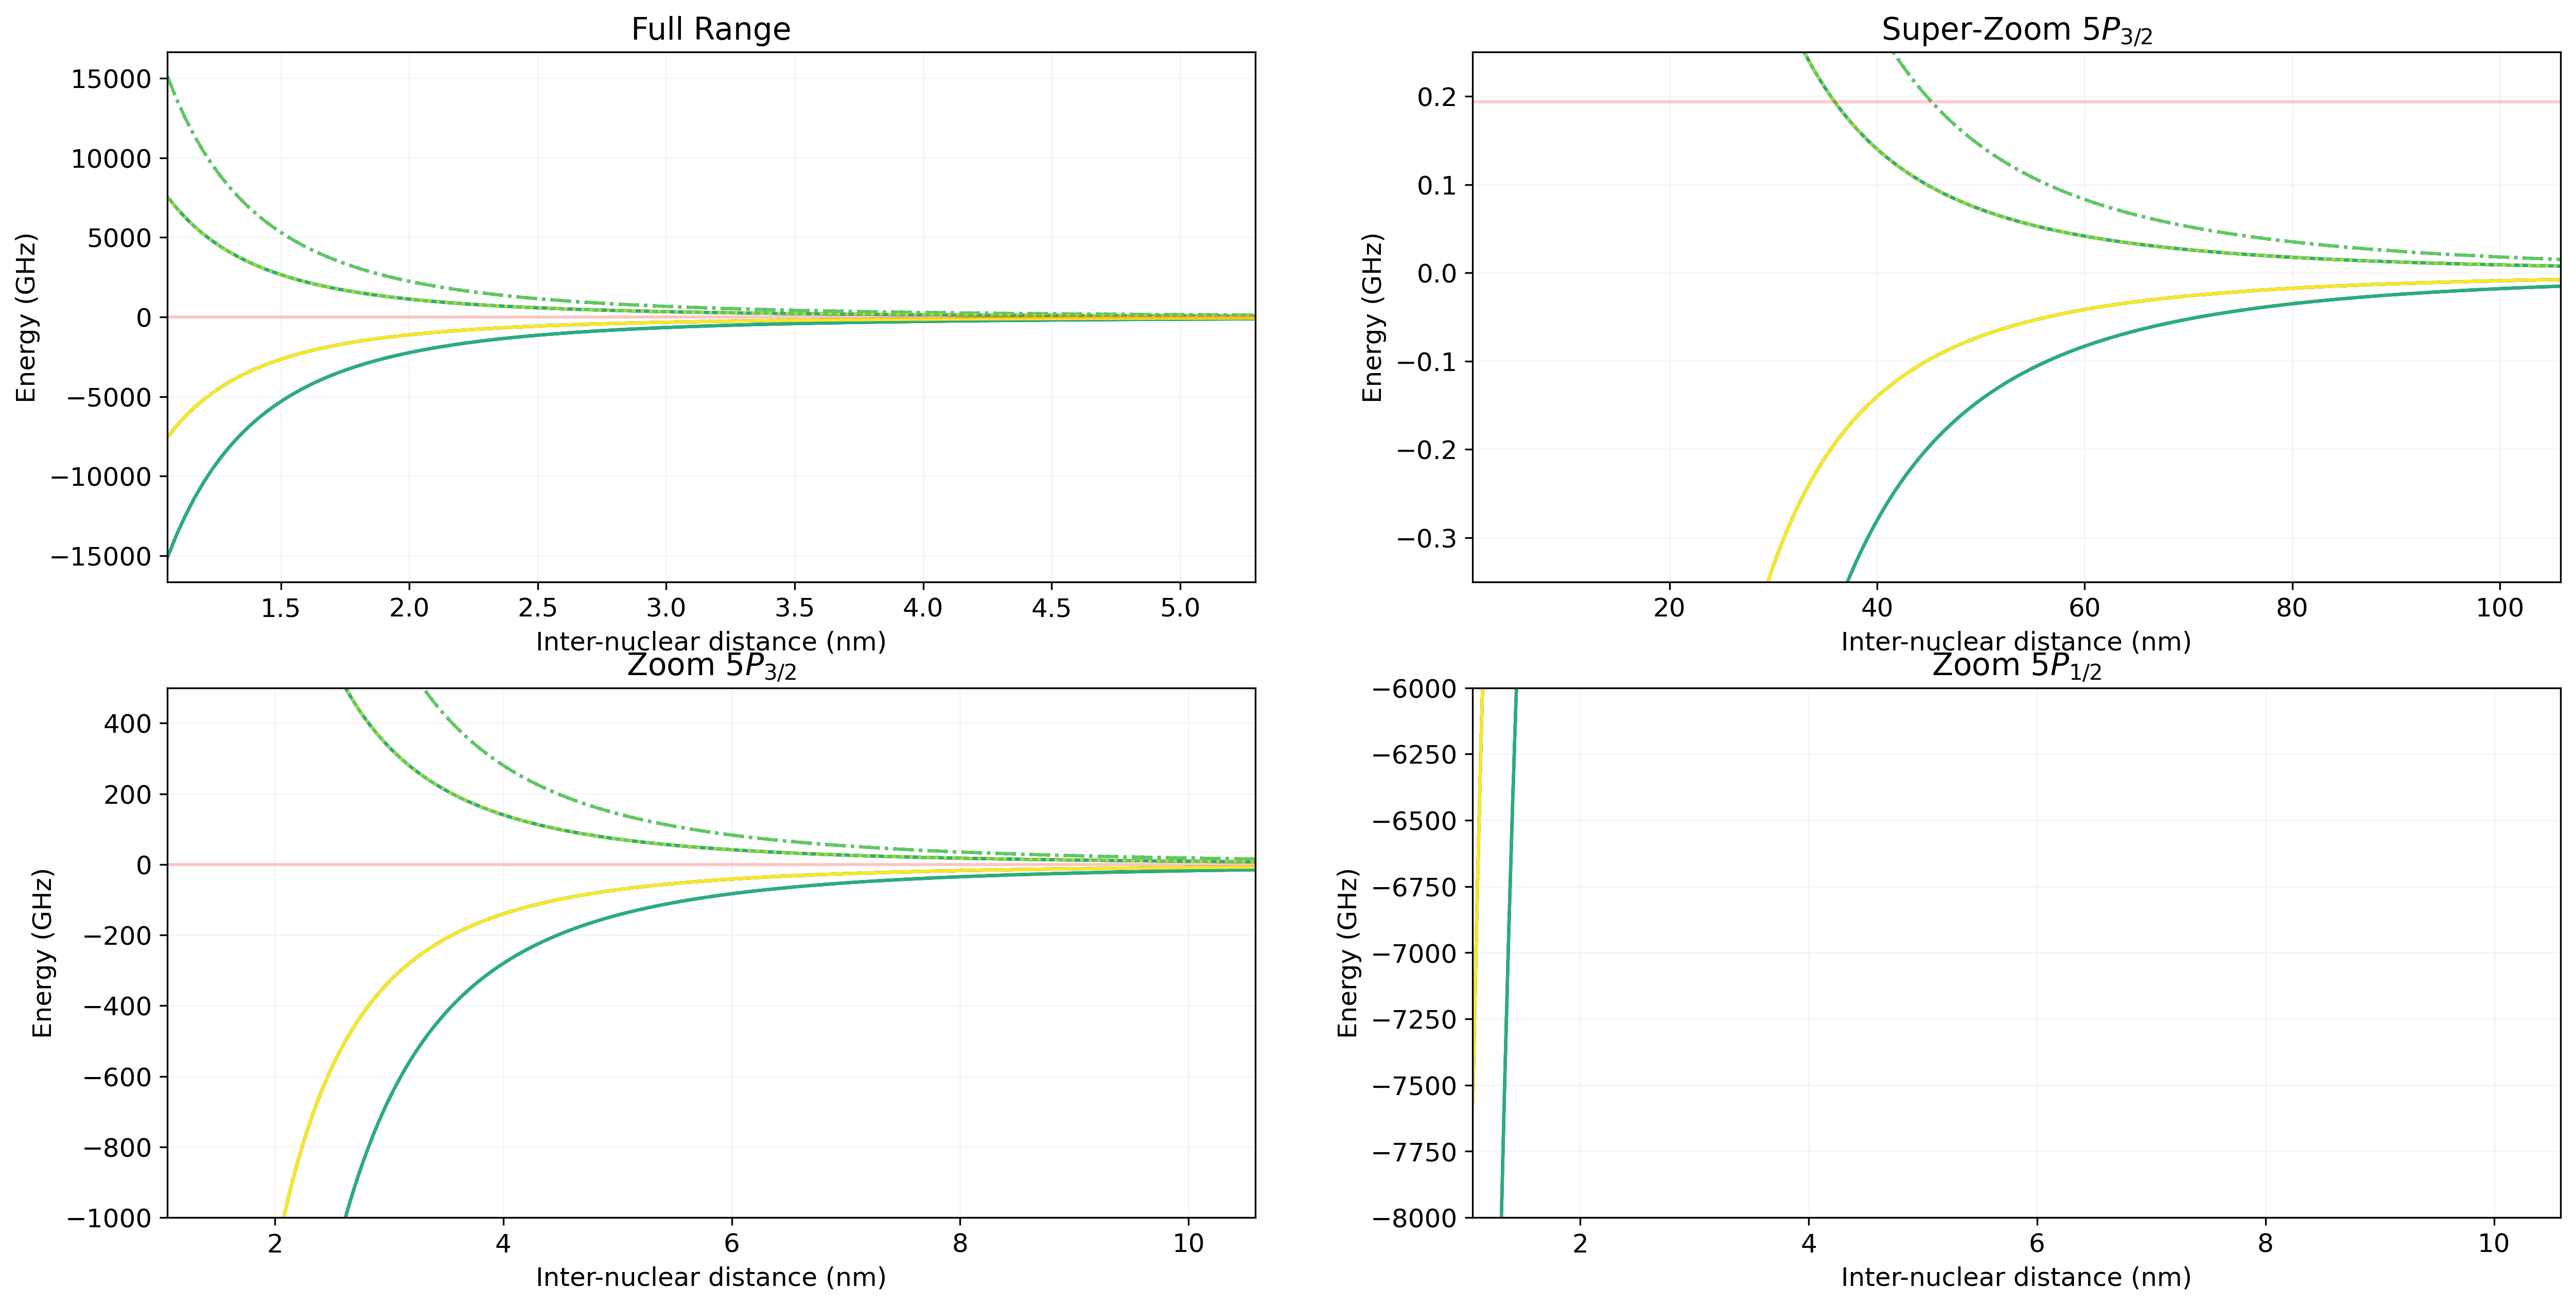

In [77]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases, **mostlySymmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        #rMatrix = mol.getBoH(C_3_val, rv, *basis).astype(float) + H_fs_phi[label]
        rMatrix = mol.getBoH(C_3_val, rv, *basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
#axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)

# Getting started w/ rotation

I have this function which I wrote a while ago:

$$
\langle j \Omega j_a j_b | L_a L_b \Lambda_a \Lambda_b; S \Sigma S_a S_b \rangle = \sqrt{\breve{S}\breve{j_a}\breve{j_b}\breve{L}} C^{j\Omega}_{LS\Lambda\Sigma} \begin{Bmatrix}
L_a & S_a & j_a\\
L_b & S_b & j_b\\
L & S & j
\end{Bmatrix}
$$

With $\breve{x}$ = 2x+1 for a given x (the symbol is a "breve" symbol), and the symbol in curly brackets is the wigner 9j symbol. It should be thought of as a function of 9 arguments.

I should verify that my understanding of this coefficient. This is a matrix element between two bases, so If I sum over all states on one side and square all the coefficients, I should get unity. This is a necessary (but insufficient condition of unitarity, but should be easier to debug than the matrix being unitary).

$$
\sum_A |\langle A | B \rangle|^2 = 1, \sum_B |\langle A | B \rangle|^2 = 1
$$

Part of the tricky thing here is that the bases I'm working with are wacky. Probably easiest to start by working with the lhs.

One thing I'm suspicious of is the L in the 9j but not in the rhs state

In [28]:
def subCoef( j_, Omega, j_a, j_b,
             L_, Lambda, L_a, L_b,
             S_, Sigma, S_a, S_b):
    def br(x):
        return 2*x+1
    
    brTerm = np.sqrt(br(S_)*br(j_a)*br(j_b)*br(L_))
    #cgcoeff = float(CG(j_,Omega,L_,Lambda,S_,Sigma).doit())
    cgcoeff = float(CG(L_,Lambda,S_,Sigma,j_,Omega).doit())
    wig = float(wigner_9j(L_a,S_a,j_a,L_b,S_b,j_b,L_,S_,j_))
    return brTerm*cgcoeff*wig

#### testing subcoef

In [29]:
# So I need to construct valid coefficients
j_b = 1/2

total = 0
L_ = 1
Lambda=0
S_ = 1
Sigma=0

for j_a in [1/2,3/2]:
    for j_ in np.arange(abs(j_a-j_b),j_a+j_b+1,1):
        for Omega in np.arange(-j_,j_+1,1):
            val =subCoef(
                    j_,Omega,j_a,j_b,
                    L_, Lambda,1,0,
                    S_, Sigma,1/2,1/2)**2 
            print('j',j_,'Omega',Omega,'j_a',j_a,'j_b',j_b,'\t',val)
            total += val
print('total:',total)



j 0.0 Omega -0.0 j_a 0.5 j_b 0.5 	 0.3333333333333333
j 1.0 Omega -1.0 j_a 0.5 j_b 0.5 	 0.0
j 1.0 Omega 0.0 j_a 0.5 j_b 0.5 	 0.0
j 1.0 Omega 1.0 j_a 0.5 j_b 0.5 	 0.0
j 1.0 Omega -1.0 j_a 1.5 j_b 0.5 	 0.0
j 1.0 Omega 0.0 j_a 1.5 j_b 0.5 	 0.0
j 1.0 Omega 1.0 j_a 1.5 j_b 0.5 	 0.0
j 2.0 Omega -2.0 j_a 1.5 j_b 0.5 	 0.0
j 2.0 Omega -1.0 j_a 1.5 j_b 0.5 	 0.0
j 2.0 Omega 0.0 j_a 1.5 j_b 0.5 	 0.6666666666666665
j 2.0 Omega 1.0 j_a 1.5 j_b 0.5 	 0.0
j 2.0 Omega 2.0 j_a 1.5 j_b 0.5 	 0.0
total: 0.9999999999999998


I have this function which I wrote a while ago:

$$
\langle j \Omega j_a j_b | L \Lambda L_a L_b; S \Sigma S_a S_b \rangle = \sqrt{\breve{S}\breve{j_a}\breve{j_b}\breve{L}} C^{j\Omega}_{LS\Lambda\Sigma} \begin{Bmatrix}
L_a & S_a & j_a\\
L_b & S_b & j_b\\
L & S & j
\end{Bmatrix}
$$

# etoa testing

In the old notebook the generated etoa matrix is not unitary, despite the matrix element seeming unitary. Very suspicious!

In [30]:
def createRotationalCouplingMatrix(caseE_Basis):
    # creates the matrix in case E, needs to be transformed to case A basis to calculate properly.
    res = np.zeros((len(caseE_Basis),len(caseE_Basis)))
    for indE, stateE in enumerate(caseE_Basis):
        ell = stateE['ell']
        res[indE,indE] = ell*(ell+1)
    return res

In [31]:
def createCaseE_BasisSuperfull(singleAtomJvals, J_rel,verbose=False):
    # for j and ell, J goes from J=j-ell or zero to J=j+ell
    # given J and j, ell goes from ell=J+j to ell = J-j
    # cases in this case_E do not have a good total angular momentum J=ell+j. For example, |j_a j_b j ell > = |1/2 1/2 1 1> couples to states
    # of J = 2 (ell = J-1) and J = 0 (ell = j+1) to help read the table in the potassium paper. however, the way I am working with this I am segmenting my states by 
    # the case A basis which does have good J, so I only want the states that will couple to my case A basis.
    caseE_BasisRef = []
    for sigma in ["g","u"]:
        for ja in [1/2]:
            for jb in singleAtomJvals:
                for j in np.arange(abs(ja-jb),ja+jb+1,1, dtype=float):
                    for ell in np.arange(J_rel-j,J_rel+j+1,1, dtype=float):
                        if verbose:
                            print(j,ell)
                        state = mol.multiplyableDict({"ja":ja, "jb": jb, "j": j, "ell":ell, "sigma":sigma})
                        if state not in caseE_BasisRef:
                            caseE_BasisRef.append(state)
    return caseE_BasisRef

In [32]:
def calcCoef(stateA,stateE, pv, verbose=False):
    stateSignedSigma = stateA['|Omega|']-stateA['|Lambda|']
    return coef_fs(stateE['ja'], stateE['jb'], stateE['j'], stateE['ell'], stateA["L"], stateA["S"], 
                              1/2, 1/2, stateA["|Lambda|"], stateSignedSigma, stateA["|Omega|"], pv, stateA["J"],verbose=verbose)

In [ ]:
def create_EtoA_Matrix_New(caseA_Basis, caseE_Basis, verbose=False):
    res = np.zeros((len(caseA_Basis), len(caseE_Basis)))
    # extraQn was [-1,1], wtf was this for?
    for extraQN in [-1]:
        for aind, stateA in enumerate(caseA_Basis):
            for eind, stateE in enumerate(caseE_Basis):
                #pv = 1 if (-1)**stateA["J"]>0 else 0
                #pv = 1 if (-1)**(stateA["J"])>0 else 0
                pv = 0
                #p = 0 if (-1)**(stateA["J"]) > 0 else 1
                res[aind, eind] = calcCoef(stateA, stateE, pv)
                if verbose:
                    print(stateE,stateA,res[aind, eind])
            if verbose:
                print('')
    return res

In [ ]:
def createLabelA(stateA):
    return'^'+str(2*stateA['S']+1)+(r'\Sigma' if stateA['Lambda']==0 else r'\Pi')+'_{'+stateA['sigma']+str(stateA['Omega'])+'}'

In [ ]:
def createLabelE(stateE):
    return r'|'+','.join([str(val) for val in [stateE['ja'],stateE['jb'],stateE['j'],stateE['ell']]])+r'\rangle'

In [ ]:
def createLabelsA(caseABasis):
    labels=[]
    for state in caseABasis:
        labels.append(createLabelA(state))
    return labels

In [ ]:
def createLabelsE(caseEBasis):
    labels=[]
    for state in caseEBasis:
        labels.append(createLabelE(state))
    return labels

In [ ]:
def coef_fs( j_a, j_b, j, ell, L,
             S, S_a, S_b,
             Lambda, Sigma, Omega, p, J, verbose=False):
    L_a = 0
    L_b = L
    sign = (-1)**(ell-Omega-J)
    frac = (1+(-1)**(L_b+ell+p)*(1-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0)))/sp.sqrt(2-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0))
    twoxm1Term = sp.sqrt(int((2*S+1)*(2*j_a+1)*(2*j_b+1)*(2*L+1)))
    cgcoeffs = CG(J,Omega,j,-Omega,ell,0).doit()*CG(L,Lambda,S,Sigma, j,Omega).doit()
    wig = wigner_9j(L_a,S_a,j_a,L_b,S_b,j_b,L,S,j)
    if verbose:
        print(J,Omega,j,-Omega,ell,0)
        print(L,Lambda, S,Sigma, j,Omega)
        print(CG(J,Omega,j,-Omega,ell,0).doit(),CG(L,Lambda,S,Sigma, j,Omega).doit())
        print(sign,frac,twoxm1Term,cgcoeffs,wig)
    return sign*frac*twoxm1Term*cgcoeffs*wig

In [43]:
def getFsH(caseABasis, caseAMostlySymHfs__):
    fsStates, hfsStates = [],[]
    for num, state in enumerate(caseABasis):
        misc.reportProgress(num, len(caseABasis))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs__, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        if state['|Omega|'] != 0: # a bit hackish
            indexes = [indexes[0]]
            signs = [signs[0]]
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs__[index] # alias
            sigma = mol.g if caseAState["sigma"] == "g" else mol.u
            nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsToJOp )
        fsStates.append(symFsState / np.sqrt(len(indexes)));    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    #print(fsStates)
    return mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)    

In [50]:
jvals=range(0,50)
#jvals = [3,10,100,1000]
superdata = {}
for sigmaParity in ['g','u']:
    for jValNum, Jv in enumerate(jvals):
        parity = ('e' if ((-1)**Jv)==1 else 'f')
        caseE_basis = createCaseE_BasisSuperfull([3/2,1/2], Jv)
        rotSymBase_E = {}
        for state in caseE_basis:
            if (-1)**state['ell'] != -1:
                continue
            label = state['sigma'] + ('e' if ((-1)**(Jv))==1 else 'f')
            if label[-1] != parity:
                continue
            if label not in rotSymBase_E:
                rotSymBase_E[label] = []
            rotSymBase_E[label].append(state)

        caseA_basis = mol.createCaseABasis_Sym([1],[0,1], [0], sigmavals=['g', 'u'],Jv=Jv)
        rotSymBase_A = {}
        for state in caseA_basis:
            label = state['sigma'] + ('e' if ((-1)**(state['J']))==1 else 'f')
            if label[-1] != parity:
                continue
            if label not in rotSymBase_A:
                rotSymBase_A[label] = []
            rotSymBase_A[label].append(state)
        # this is the symmetry which will be analyzed in this round
        label = sigmaParity+parity

        if (-1)**Jv==-1:
            wBaseA = rotSymBase_A[label]
            workingBaseA = [wBaseA[ind] for ind in [0,1,2,3,5,4,6]]
            workingBaseE = [rotSymBase_E[label][ind] for ind in [4,5,0,1,2,3]]
        else:
            wBaseA = rotSymBase_A[label]
            workingBaseA = [wBaseA[ind] for ind in [0,1,2,3,5,4,6]]
            workingBaseE = [rotSymBase_E[label][ind] for ind in [4,5,0,1,2,3]]
        etoa = create_EtoA_Matrix_New(workingBaseA, workingBaseE, verbose=False).T
        RCM = createRotationalCouplingMatrix(workingBaseE)#*mc.Rb87_M*1e-9**2/(mc.hbar**2)
        rotationalEnergy = etoa.conj().T@RCM@etoa
        curveLabel=label+str(Jv)
        superdata[curveLabel] = []
        
        caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], sigmavals=['g', 'u'], Jv=Jv)
        fsEnergy = getFsH(workingBaseA,caseAMostlySymHfs)

        for rv in Rvals:
            
            #rMatrix = mol.getBoH(C_3_val, rv, *workingBaseA).astype(float)
            rMatrix = mol.get_H_BO(C_3_val, rv, workingBaseA).astype(float)
            rMatrix += rotationalEnergy*mc.hbar**2/(mc.Rb87_M)*(1/rv**2)
            rMatrix += fsEnergy
            superdata[curveLabel].append(sorted(np.real(np.linalg.eigvals(rMatrix))))

        if False:
            labels = createLabelsE(workingBaseE)
            labels = createLabelsA(workingBaseA)
            print(RCM)
            print(np.c_[etoa, etoa@etoa.T])
            display(Latex('$'+r'\\'.join(labels)+'$'))
            display(Latex('$'+'~~~~~~~~'.join(labels)+'$'))
            print(etoa)
            print(rotationalEnergy)
print('\ndone')

85.7%                     
done


In [47]:
for x in workingBaseE:
    print(x)
#print(workingBaseE)

{'ja': 0.5, 'jb': 0.5, 'j': 1.0, 'ell': 3.0, 'sigma': 'u'}
{'ja': 0.5, 'jb': 0.5, 'j': 1.0, 'ell': 5.0, 'sigma': 'u'}
{'ja': 0.5, 'jb': 1.5, 'j': 1.0, 'ell': 3.0, 'sigma': 'u'}
{'ja': 0.5, 'jb': 1.5, 'j': 1.0, 'ell': 5.0, 'sigma': 'u'}
{'ja': 0.5, 'jb': 1.5, 'j': 2.0, 'ell': 3.0, 'sigma': 'u'}
{'ja': 0.5, 'jb': 1.5, 'j': 2.0, 'ell': 5.0, 'sigma': 'u'}


In [ ]:
for x in workingBaseA:
    print(x)

{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 1, '|Sigma|': 1, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 0, 'Phi': 0, 'sigma_vxz': -1, 'sigma_v2xz': -1, 'J': 4}
{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 1, '|Sigma|': 1, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 0, 'Phi': 0, 'sigma_vxz': 1, 'sigma_v2xz': 1, 'J': 4}
{'L': 1, '|Lambda|': 0, 'sigma': 'u', 'S': 0, '|Sigma|': 0, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 0, 'Phi': 0, 'sigma_vxz': -1, 'sigma_v2xz': -1, 'J': 4}
{'L': 1, '|Lambda|': 0, 'sigma': 'u', 'S': 1, '|Sigma|': 0, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 0, 'Phi': 0, 'sigma_vxz': 1, 'sigma_v2xz': 1, 'J': 4}
{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 1, '|Sigma|': 0, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 1, 'Phi': -1, 'sigma_vxz': -1, 'sigma_v2xz': -1, 'J': 4}
{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 0, '|Sigma|': 0, 'I': 0, '|Iota|': 0, 'i_a': 0, 'i_b': 0, '|Omega|': 1, 'Phi': -1, 'sigma_vxz': 1, 'sigma_v2xz': 1, 'J':

In [83]:
def getColors(num, rgb=False, cmap='nipy_spectral', cmStr=None):
    """
    Get an array of colors, typically to use for plotting.

    :param rgb: an option to return the colors as an rgb tuple instead of a hex.
    :param num: number of colors to get
    :return: the array of colors, hex or rgb (see above)
    """
    if type(cmap)==type(''):
        cmStr = cmap
    if cmStr is not None:
        cmapRGB = mpl.cm.get_cmap(cmStr, num+1)
        c = [cmapRGB(i)[:-1] for i in range(num+1)][:]
        c = c[1:]
    else:
        c = [cmap(float(i)/(num))[:-1] for i in range(num+1)][:]

    
    if rgb:
        return c
    # the negative of the first color
    c2 = [tuple(np.array((1, 1, 1)) - np.array(color)) for color in c]
    c = ['#%02x%02x%02x' % tuple(int(255 * color[i]) for i in range(len(color))) for color in c]
    c2 = ['#%02x%02x%02x' % tuple(int(255 * color[i]) for i in range(len(color))) for color in c2]
    return c, c2

In [84]:
import cmasher as cmr

In [92]:
def paperFigureSettings():
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['stixsans']
    mpl.rcParams['font.size'] = 7
    mpl.rcParams['text.latex.preamble'] = r'\usepackage[eulergreek]{sansmath}\sansmath\usepackage{amsmath}'

In [94]:
mpl.rcParams['figure.dpi']=400

In [110]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Saving...
Rendering


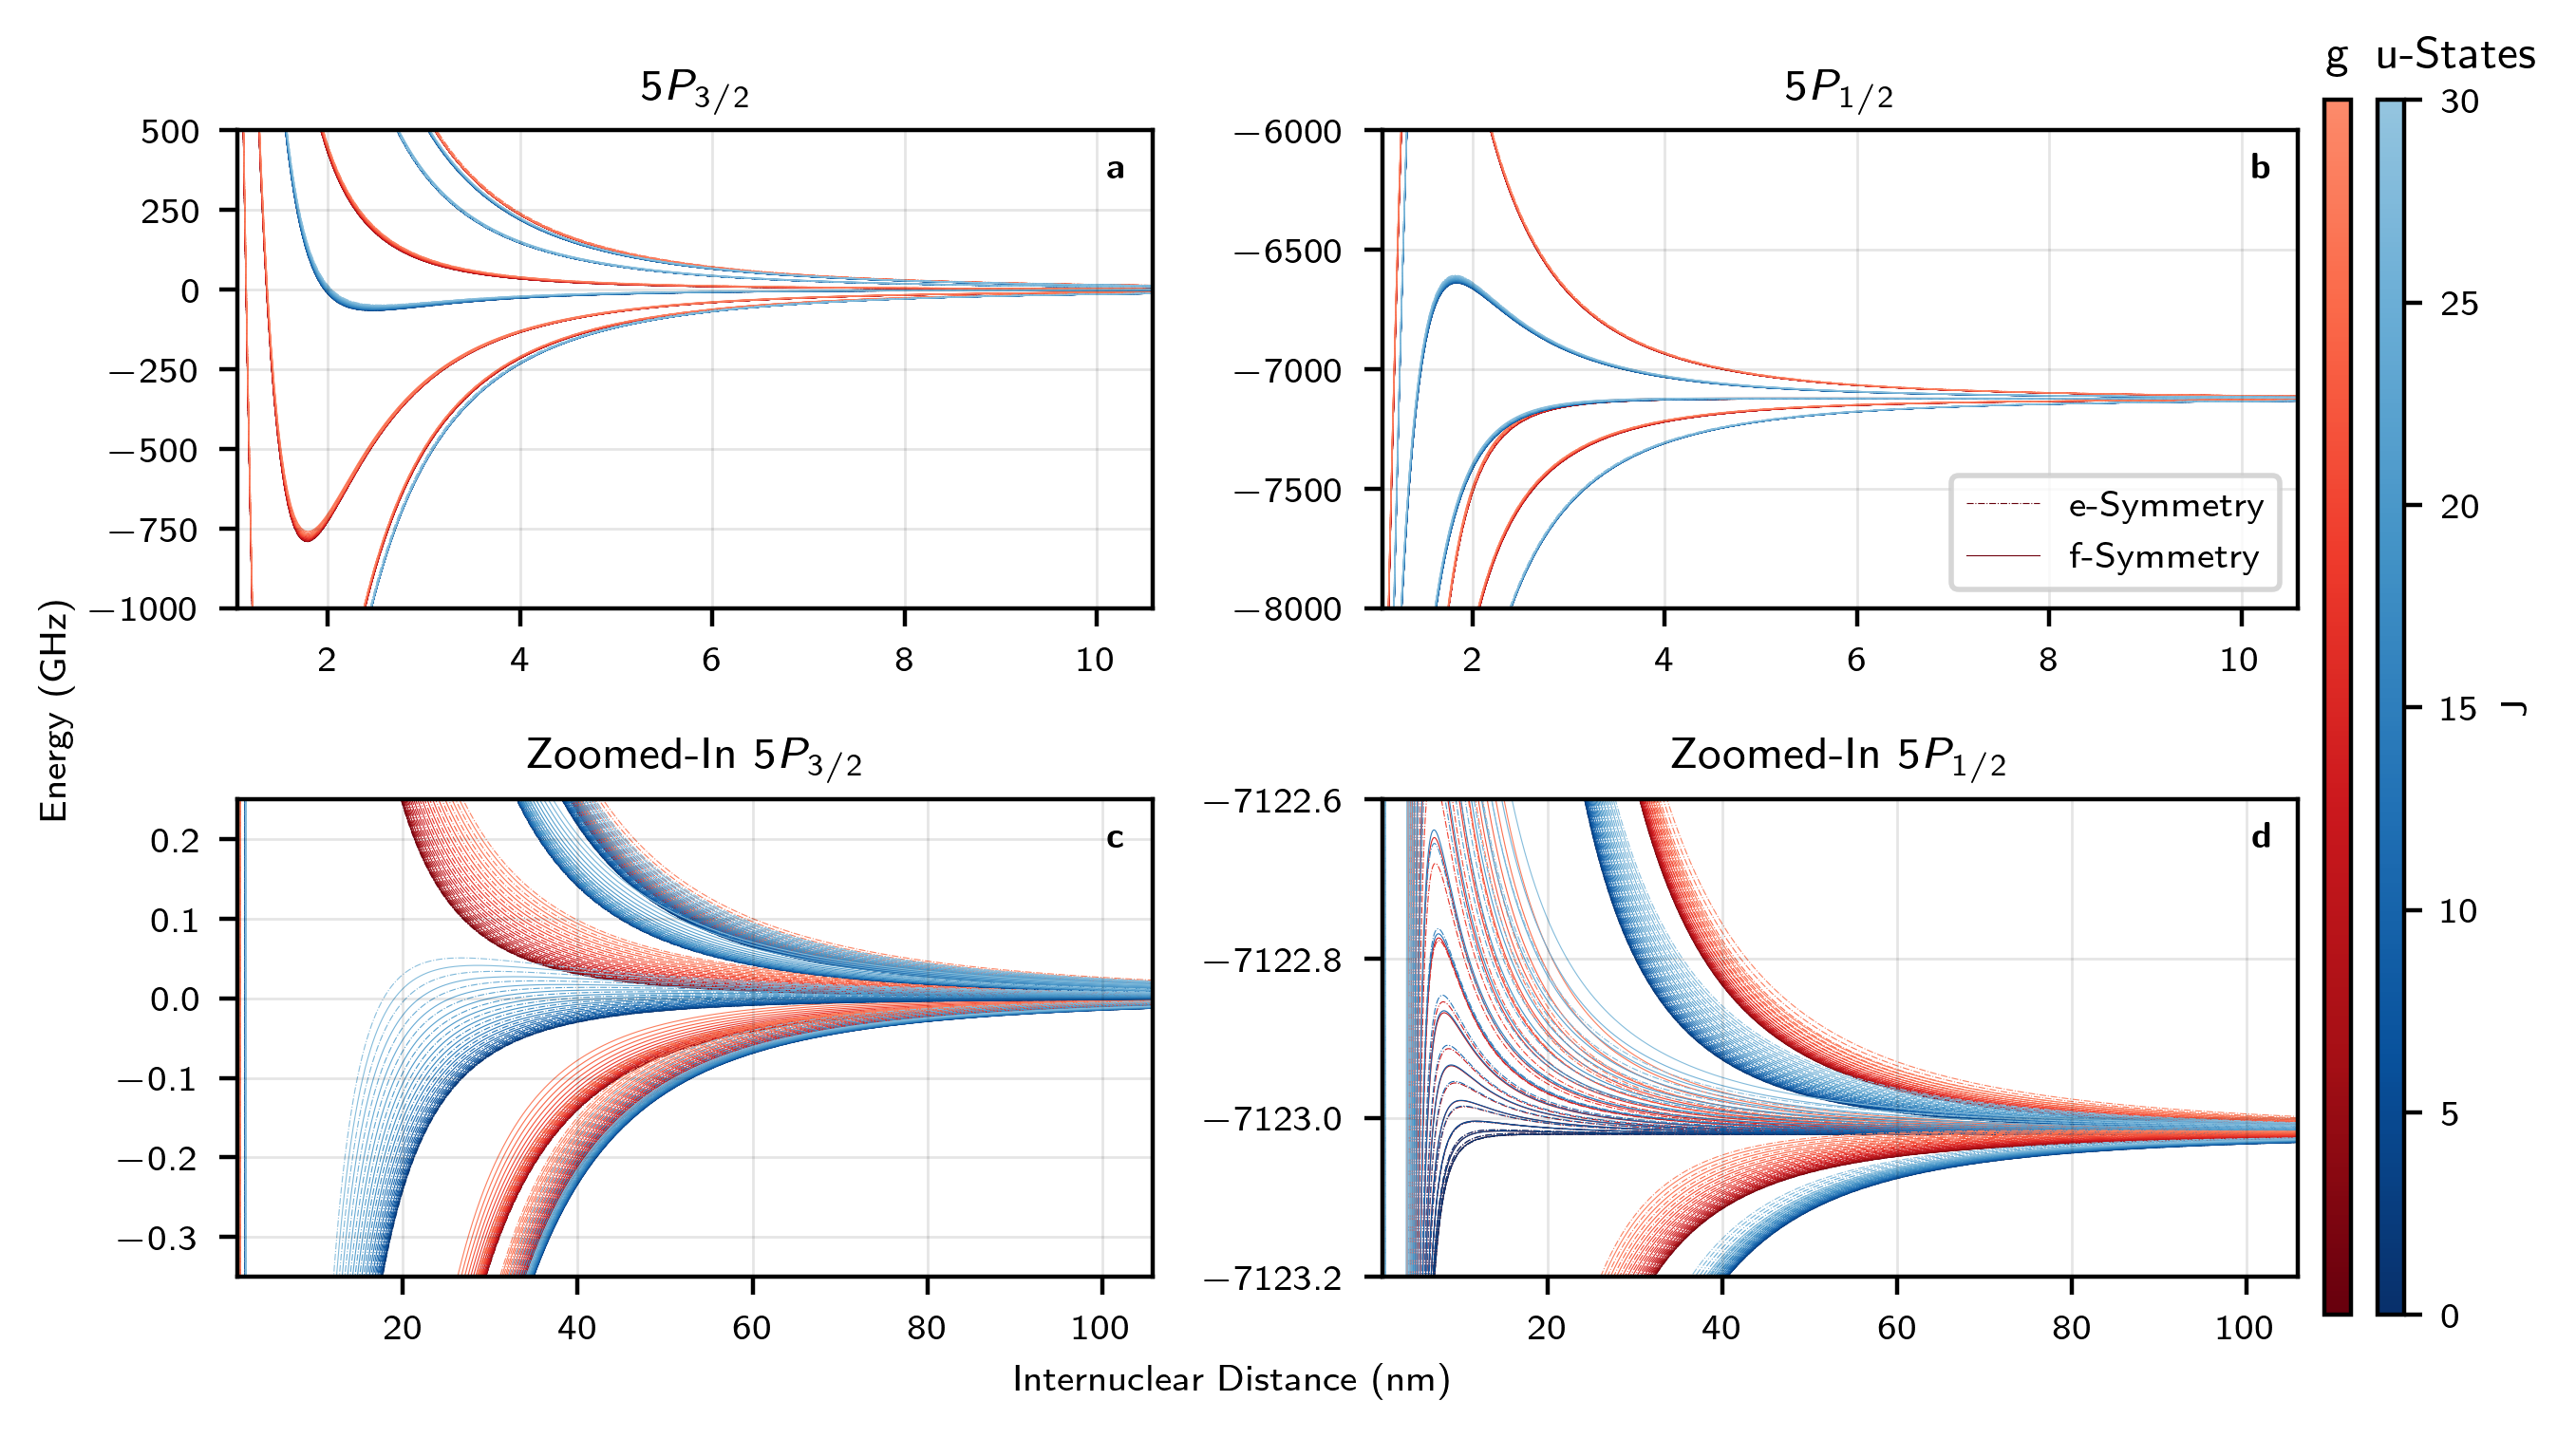

In [128]:
paperFigureSettings()
fig, axs = plt.subplots(2,2,figsize=(7,4))
fig.subplots_adjust(wspace=0.25,hspace=0.4)
JvLim = 30
cbLim = JvLim # scale it to avoid white colors
gCmap = truncate_colormap(plt.cm.Reds_r, 0, 0.6)
uCmap = truncate_colormap(plt.cm.Blues_r, 0, 0.6)
colors_u, _ = getColors(cbLim+1,cmap=uCmap)
colors_g, _ = getColors(cbLim+1,cmap=gCmap)

for ax in axs.flatten():
    fLabeled=False
    eLabeled=False
    for label in superdata.keys():
        ls = '-' if label[1] == 'f' else '-.'
        Jv = int(label[2:])
        if Jv>JvLim:
            continue
        if label[0]=='u':
            color = colors_u[Jv]
        elif label[0]=='g':
            color = colors_g[Jv]
        for linenum, mdata in enumerate(misc.transpose(superdata[label])):
            if label=='gf1' and not fLabeled:
                legendLabel='f-Symmetry'
                fLabeled=True
            elif label=='ge0' and not eLabeled:
                legendLabel='e-Symmetry'
                eLabeled=True
            else:
                legendLabel=None
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle=ls, lw=0.2, label=legendLabel, zorder=-linenum)
        
for ax, label in zip(axs.flatten(), ['a','b','c','d']):
    ax.grid(alpha=0.1, color='k', lw=0.5)
    ax.text(0.95, 0.9, r'\textbf{'+label+'}',transform=ax.transAxes)
    #ax.set_facecolor('#DDDDDD')
    

axs[0,0].set_title('$5P_{3/2}$')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[0,0].set_ylim(-1000, 500)

axs[1,0].set_title('Zoomed-In $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[1,0].set_ylim(-0.35, 0.25)

axs[0,1].set_title('$5P_{1/2}$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[0,1].set_ylim(-8000, -6000);
axs[0,1].legend(loc='lower right')

axs[1,1].set_title('Zoomed-In $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)

center=-7122.9
width=0.3
axs[1,1].set_ylim(center-width, center+width);

fig.subplots_adjust( right=0.9 )

norm = mpl.colors.BoundaryNorm(np.arange(JvLim), JvLim)
sm = plt.cm.ScalarMappable( cmap = gCmap, norm = plt.Normalize(vmin=0, vmax=cbLim) )
cbar_ax = fig.add_axes( [0.91, 0.1, 0.01, 0.8] )
cb = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(cbLim)+0.5, spacing='uniform')
cb.ax.set_title("g")
cb.set_ticks([])

sm = plt.cm.ScalarMappable(cmap=uCmap, norm=plt.Normalize(vmin=0, vmax=cbLim))
cbar_ax2 = fig.add_axes([0.93, 0.1, 0.01, 0.8])
cb = fig.colorbar(sm, cax=cbar_ax2, spacing='uniform')
cb.ax.set_title("u-States", loc='left')
cb.set_label('J')

fig.text(0.05, 0.5, 'Energy (GHz)', rotation=90, va='center')
fig.text(0.5, 0.05, 'Internuclear Distance (nm)', ha='center')

print('Saving...')
plt.savefig('Paper_Rotation.png',dpi=600,bbox_inches='tight')
print('Rendering')